In [4]:
import h5py as h5
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    validation_curve,
    train_test_split,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    log_loss,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [5]:
np.random.seed(42)

In [6]:
# Grab extracted features and labels (TRAIN SET).
with h5.File('features_train.h5', 'r') as file:
    X_train, y_train = file['images'][:], file['labels'][:]
    classes = file['classes'][:]

### SGD Classification

In [7]:
# Params used to find the best estimator.
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'eta0': [0.0, 0.1, 1.0],
    'max_iter': [5000, 10000, 15000,  20000]
}

model = GridSearchCV(
    SGDClassifier(),
    param_grid=params,
    cv=3,
    n_jobs=-1, # -1: all cores
    verbose=2,
)

In [8]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   35.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.0, 0.1, 1.0],
                         'max_iter': [5000, 10000, 15000, 20000]},
             pre_dispatch='2*n_j

In [9]:
print('Best estimator is', model.best_estimator_)
print('Best score is', model.best_score_)

Best estimator is SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=5000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score is 0.9096385542168676


### Train the best model

In [10]:
best_model = model.best_estimator_

best_model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=5000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Cross-Validation Score

In [11]:
cvscore = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

In [12]:
f'Cross Validation Score is ~{round(np.average(cvscore), 3) * 100}%.'

'Cross Validation Score is ~88.5%.'

### Confusion matrix

In [13]:
y_train_preds = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
)

In [14]:
confusion_matrix(y_train, y_train_preds)

array([[215,  34],
       [ 15, 234]])

### Precision

In [15]:
precision_score(y_train, y_train_preds)

0.8731343283582089

### Recall

In [16]:
recall_score(y_train, y_train_preds)

0.9397590361445783

### F1-Score (harmonic mean)

In [17]:
f1_score(y_train, y_train_preds)

0.9052224371373307

### Precision recall curve

In [18]:
y_scores = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1,
)

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

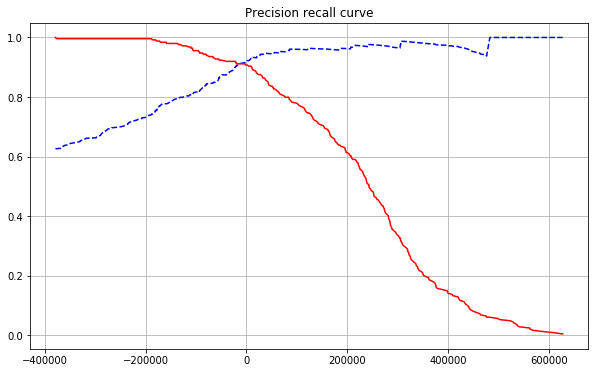

In [20]:
plt.figure(figsize=(10, 6))
plt.title('Precision recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.grid()
plt.show()

### ROC Curve

In [21]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

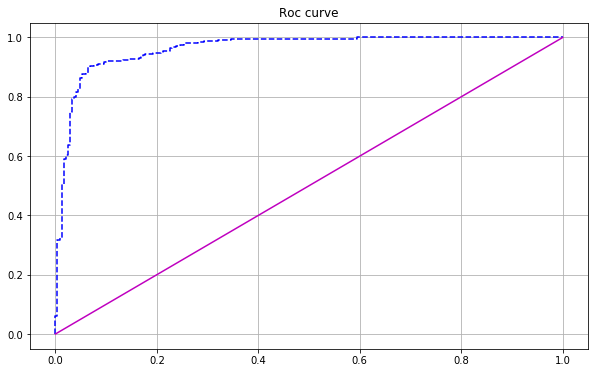

In [22]:
plt.figure(figsize=(10, 6))
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b--')
plt.plot([0, 1], [0, 1], 'm-')
plt.grid()
plt.show()

### ROC-AUC Score

In [23]:
roc_auc_score(y_train, y_scores)

0.9633393009790164

### Learning curve

In [24]:
lrn_curve = learning_curve(
    best_model,
    X_train,
    y_train,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
)

In [25]:
train_sizes_abs, train_scores, val_scores = lrn_curve

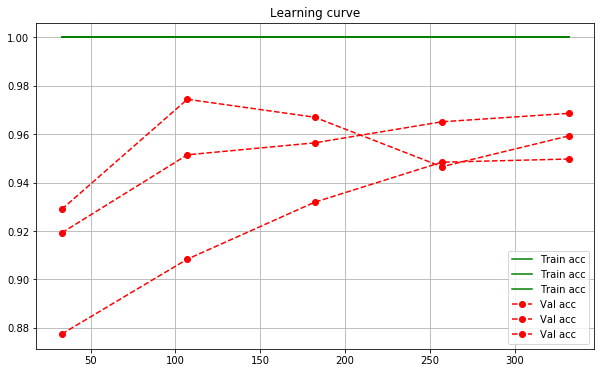

In [26]:
plt.figure(figsize=(10, 6))
plt.title('Learning curve')
plt.plot(train_sizes_abs, train_scores, 'g-', label='Train acc')
plt.plot(train_sizes_abs, val_scores, 'ro--', label='Val acc')
plt.legend(loc='best')
plt.grid()
plt.show()

In [27]:
def plot_learning_curves(model, X, y):
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2)
    train_loss = []
    val_loss = []
    
    for m in np.linspace(2, len(X_train)-2, 20, dtype=int):
        model.fit(X_t[:m], y_t[:m])
        y_train_predict = model.predict(X_t[:m])
        y_val_predict = model.predict(X_v)
        train_loss.append(log_loss(y_t[:m], y_train_predict))
        val_loss.append(log_loss(y_v, y_val_predict))
    
    plt.figure(figsize=(10, 6))
    plt.title('Learning curve')
    plt.plot(train_loss, 'r-+', label='Train Loss')
    plt.plot(val_loss, 'b-', label='Val Loss')
    plt.legend(loc='best')
    plt.show()

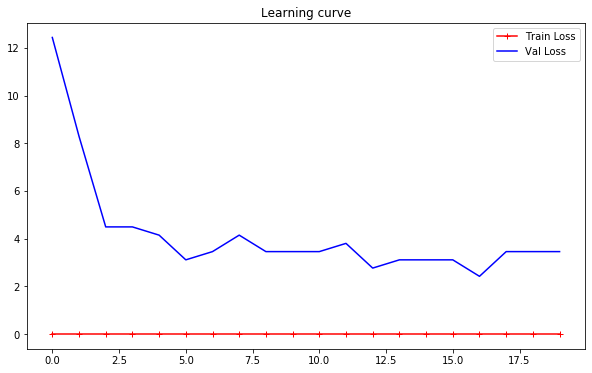

In [28]:
plot_learning_curves(best_model, X_train, y_train)